In [1]:
#Here we will implement previous code with the DLC package. This requires H5 files...

In [1]:
#Imports

import pandas as pd

import os
import re
import numpy as np
from sympy  import *
import matplotlib.pyplot as plt
import dlc2kinematics
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from dlc2kinematics import Visualizer2D
#classes imports
from preprocessing.classes import FilterandThresholds
#Initialize classes
splitter = FilterandThresholds('tester')

/Users/carlospineda/PycharmProjects/scientificProject/preprocessing/classes.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv[scorer, 'Animal Infor','ID'] = np.nan
/Users/carlospineda/PycharmProjects/scientificProject/preprocessing/classes.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv[scorer, 'Animal Infor','Condition'] = np.nan
/Users/carlospineda/PycharmProjects/scientificProject/preprocessing/classes.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

IndexError: invalid index to scalar variable.

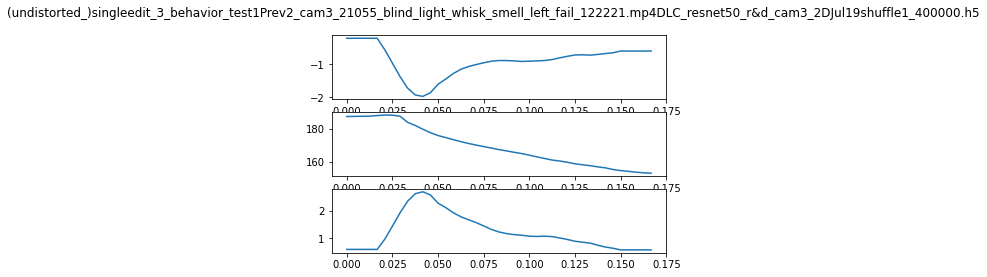

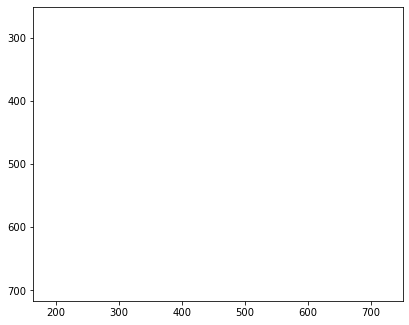

In [2]:
#Lets see what the dlc2kinematics has to offer

#In this we want to import our files, load the data and extract kinematics
#path = r''
path = r'/Users/carlospineda/Desktop/TEMP Reaching Results for Code Dev/camera3/'
configCam3 = r'/Users/carlospineda/Desktop/TEMP Reaching Results for Code Dev/config/config.yaml'
files = [file for file in os.listdir(path)]
scale = 2.9

#Allocate datframes
data_singlereach_allcombined = pd.DataFrame()
data_singlereach_alladded_combined_extention = pd.DataFrame()
data_singlereach_alladded_combined_retraction = pd.DataFrame()
data_velocity_alladded_combined_extention=pd.DataFrame()
data_velocity_alladded_combined_retraction= pd.DataFrame()
data_speed_alladded_combined_extention=pd.DataFrame()
data_speed_alladded_combined_retraction= pd.DataFrame()
df_speed_mean_comb = []
velocity = []
time_saver =[]
fps = 240
for file in files:
    time_saver =[]

    if 'left' in file:

        data_singlereach, bodyparts, scorer = dlc2kinematics.load_data(path + file, smooth = True, filter_window=7)
        #print(data_singlereach)

        data_singlereach = data_singlereach[data_singlereach[scorer, 'WristL', 'likelihood'] > 0.2]
        #SCALE THE DATA SO THAT THE COORDS ARE IN MM -
        data_singlereach_scaled = data_singlereach.apply(lambda x: x/scale if x.name not in ['likelihood'] else x)

        data_singlereach_scaled = data_singlereach_scaled[data_singlereach_scaled[scorer, 'WristL', 'likelihood'] > 0.1]
        #print(data_singlereach_scaled)
        #%% Threshold bad predictions

        #print(data_singlereach_scaled)
        #RESCALE THE REACHES SO YOU CAN PLOT THEM TOGETHER
        #Try1: substract all numbers by however much you had to substract the first to get it to 0. The resulting dataset should be kept separate from the original.




        data_singlereach_scaled_filled = splitter.rexsearch(file, data_singlereach_scaled, scorer_bool = True, scorer=scorer,fps_bool=True, fps = fps, durpercent_bool=True)
        #print(data_singlereach_scaled_filled)
        #print(data_singlereach_scaled_filled[scorer, 'Animal Infor', 'percent duration'])

        #we want to split the data into the two basic reaching components: extention and retraction
        data_extention = data_singlereach_scaled_filled.iloc[0: np.argmin(data_singlereach_scaled_filled[scorer]['WristL']['x'].iloc[0:-2]), :]
        data_extention = splitter.rexsearch(file, data_extention, scorer_bool=True, scorer=scorer,fps_bool=True, fps = fps, durpercent_bool=True)
        data_retraction = data_singlereach_scaled_filled.iloc[np.argmin(data_singlereach_scaled_filled[scorer]['WristL']['x'].iloc[0:-2]):-2, :]
        data_retraction = splitter.rexsearch(file, data_retraction, scorer_bool=True, scorer=scorer,fps_bool=True, fps = fps, durpercent_bool=True)
        #print(type(data_extention[scorer, 'WristL', 'x'].iloc[2]))
        ##print(np.argmin(data_singlereach_scaled_filled[scorer]['WristL']['x'].iloc[0:-2]))

         #Compute and concatenate velocity profiles of the individual. Modify these
        #print(file)
        df_vel_extent = dlc2kinematics.compute_velocity(data_extention,bodyparts=['WristL'], filter_window = 9, order=1)
        df_vel_retract = dlc2kinematics.compute_velocity(data_retraction, bodyparts=['WristL'], filter_window=9, order=1)
        df_speed_extent = dlc2kinematics.compute_speed(data_extention,bodyparts=['WristL'], filter_window=9, order=1)
        df_speed_retract = dlc2kinematics.compute_speed(data_retraction,bodyparts=['WristL'], filter_window=9, order=1)
        #Add time to these dataframes


        df_vel_extent = splitter.rexsearch(file, df_vel_extent, scorer_bool = True, scorer=scorer,fps_bool=True, fps = fps,durpercent_bool=True)
        df_vel_retract = splitter.rexsearch(file, df_vel_retract, scorer_bool = True, scorer=scorer,fps_bool=True, fps = fps, durpercent_bool=True)
        df_speed_extent = splitter.rexsearch(file, df_speed_extent, scorer_bool = True, scorer=scorer,fps_bool=True, fps = fps, durpercent_bool=True)
        df_speed_retract = splitter.rexsearch(file, df_speed_retract, scorer_bool = True, scorer=scorer,fps_bool=True, fps = fps, durpercent_bool=True)

        #Plot each dataset to check for homogeneity.

        #print(len(data_extention))
        #print(len(data_retraction))
        fig, axs = plt.subplots(3)
        fig.suptitle(file)
        axs[0].plot(df_vel_extent[scorer, 'Time Scale', 'Time'], df_vel_extent[scorer, 'WristL','x'])
        axs[1].plot(data_extention[scorer, 'Time Scale', 'Time'],data_extention[scorer, 'WristL', 'x'])
        axs[2].plot(df_speed_extent[scorer, 'Time Scale', 'Time'],df_speed_extent[scorer, 'WristL', 'speed'])

        #CONCATENATE A MASTER DF
        data_singlereach_allcombined = pd.concat([data_singlereach_allcombined, data_singlereach_scaled_filled], ignore_index = True)
        #CONCATENATE DATAFRAMES
        data_singlereach_alladded_combined_extention = pd.concat([data_singlereach_alladded_combined_extention, data_extention], ignore_index = True)
        data_singlereach_alladded_combined_retraction = pd.concat([data_singlereach_alladded_combined_retraction, data_retraction], ignore_index = True)

        #CONCATENATE VELOCITY DATAFRAMES
        data_velocity_alladded_combined_extention = pd.concat([data_velocity_alladded_combined_extention, df_vel_extent], ignore_index = True)
        data_velocity_alladded_combined_retraction = pd.concat([data_velocity_alladded_combined_retraction, df_vel_retract], ignore_index = True)

        #CONCATENATE SPEED DATAFRAMES
        data_speed_alladded_combined_extention = pd.concat([data_speed_alladded_combined_extention, df_speed_extent], ignore_index = True)
        data_speed_alladded_combined_retraction = pd.concat([data_speed_alladded_combined_retraction, df_speed_retract], ignore_index = True)

        #Compute and concatenate velocity profiles of the individual
        viz = Visualizer2D(configCam3, path + file)
        viz.view(show_axes=True, show_grid=True)

In [4]:
#We're getting rid of the score level to avoid problems
data_velocity_alladded_combined_extention = data_velocity_alladded_combined_extention.droplevel(level = [0, 1], axis =1)
data_speed_alladded_combined_extention = data_speed_alladded_combined_extention.droplevel(level =[0, 1], axis = 1)

In [5]:
print(data_singlereach_allcombined[scorer, 'Platform'] )

coords           x           y  likelihood
0       148.139974  161.966646    0.343427
1       148.165749  161.919761    0.343218
2       148.191525  161.872875    0.343415
3       148.217300  161.825990    0.343563
4       148.264560  161.789800    0.343638
...            ...         ...         ...
7284    151.770568  160.813009    0.343762
7285    151.790953  160.807985    0.343895
7286    151.828912  160.820456    0.340938
7287    151.866871  160.832927    0.339868
7288    151.904829  160.845398    0.338347

[7289 rows x 3 columns]


/Users/carlospineda/opt/anaconda3/envs/Reaching_Grasping/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


coords Condition Reach Number     ID     speed  likelihood  percent duration  \
0          blind            1  21055  1.290281    0.326605         50.000000   
1          blind           11  11090  0.259399    0.342113         50.000000   
2          blind           14  21064  1.396070    0.340032         50.000000   
3          blind           16  11090  1.647648    0.330751         50.000000   
4          blind           16  21064  0.798407    0.342043         50.000000   
5          blind            2  11093  1.315935    0.283417         50.000000   
6          blind            2  21055  0.414995    0.338940         50.000000   
7          blind           20  21064  0.537829    0.343987         50.000000   
8          blind            3  11094  0.974866    0.303331         50.000000   
9          blind            3  21055  1.226480    0.333270         50.048780   
10         blind            6  21064  1.263804    0.344267         50.000000   
11         blind            7  11092  0.

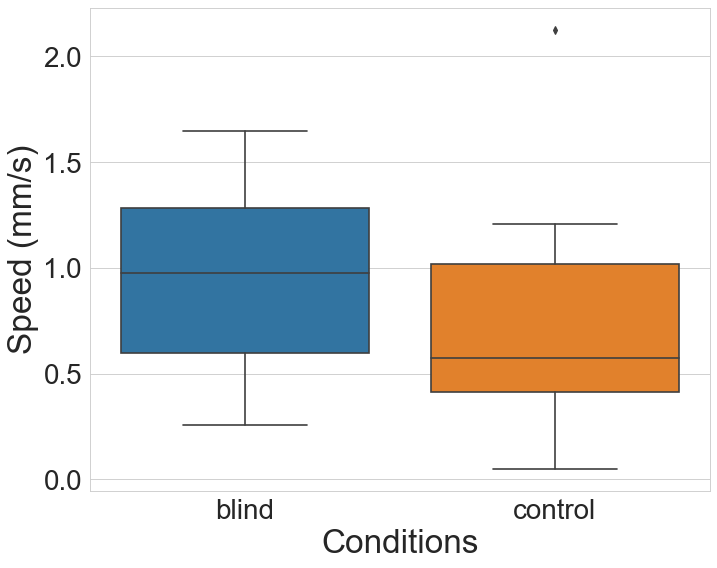

In [6]:
#% Calculate average speed
speed_groupmean = data_speed_alladded_combined_extention.groupby(['Condition', 'Reach Number', 'ID']).mean()
speed_groupmean.reset_index(inplace = True)
print(speed_groupmean)

#Plot
speedboxplot = plt.figure(figsize=(10,8), dpi= 80)
sns.set_style('whitegrid')
speedboxplot = sns.boxplot(x = 'Condition', y = 'speed', data = speed_groupmean)
#sns.color_palette('Set2')
#invert_yaxis()
plt.xlabel('Conditions', fontsize=30)
plt.ylabel('Speed (mm/s)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
fig1 = speedboxplot.get_figure()
fig1.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_speedbycondition_552022.png')

No handles with labels found to put in legend.


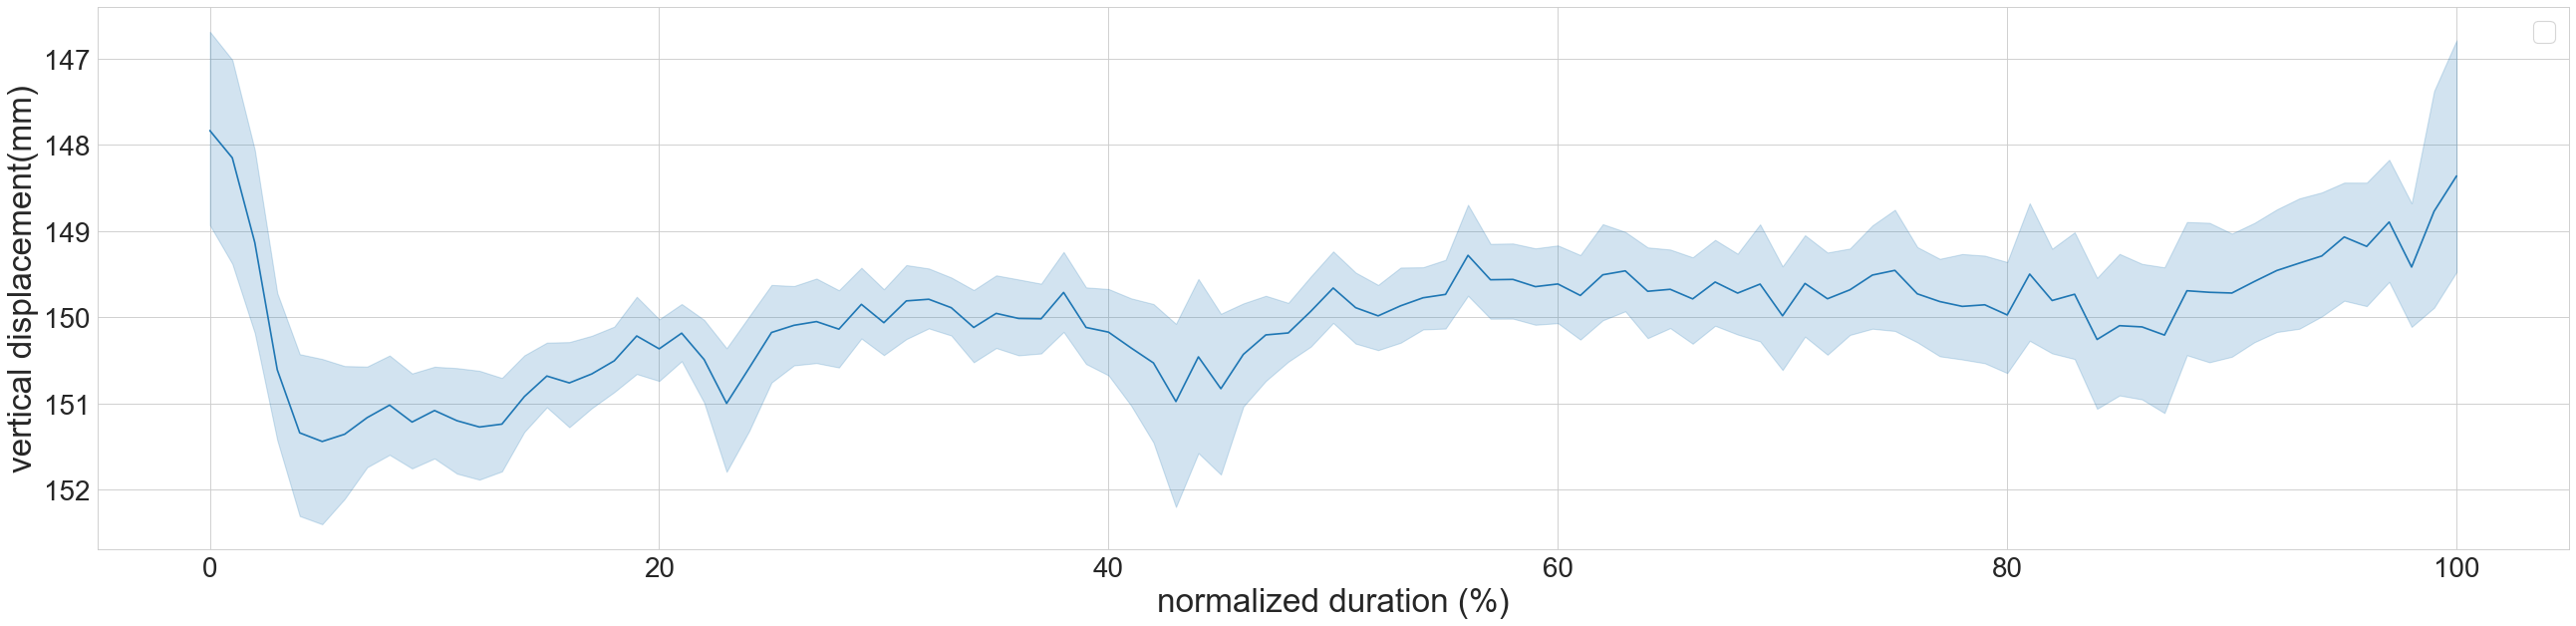

In [7]:
#PLOT THE ENTIRE REACH
ax = plt.figure(figsize=(40,9), dpi= 80)
sns.set_style('whitegrid')
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_allcombined[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_allcombined[scorer, 'Platform', 'x'],data=data_singlereach_allcombined)
ax.invert_yaxis()
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('vertical displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig20= ax.get_figure()
fig20.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_ALL_WristL_y_condition_552022.png')

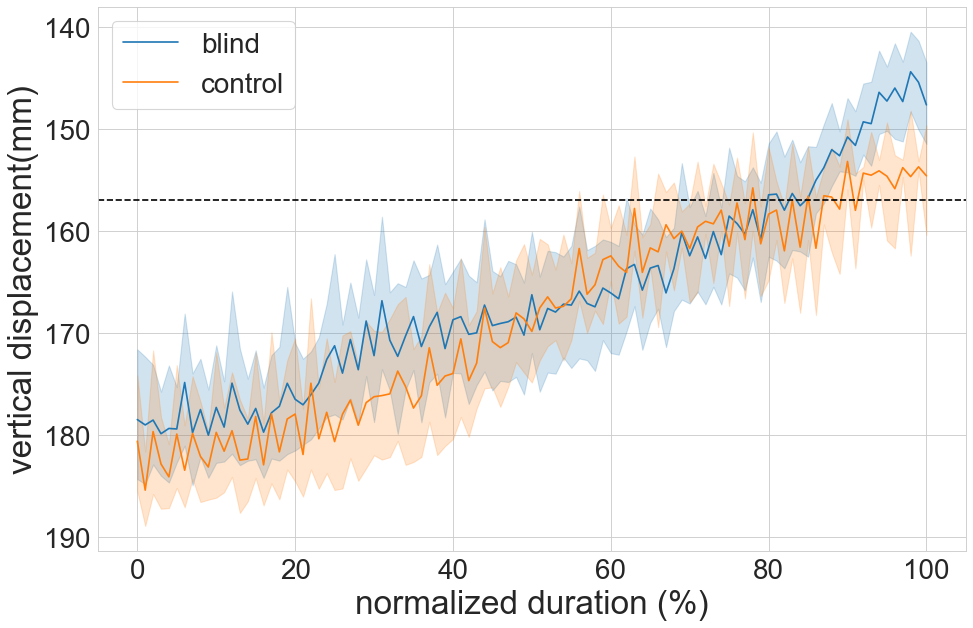

In [8]:
ax = plt.figure(figsize=(14,9), dpi= 80)
sns.set_style('whitegrid')
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_extention[scorer, 'WristL', 'y'],hue = data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'Condition'], data=data_singlereach_alladded_combined_extention)
ax.invert_yaxis()
ax.axhline(157, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('vertical displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig2= ax.get_figure()
fig2.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_WristL_y_condition_552022.png')

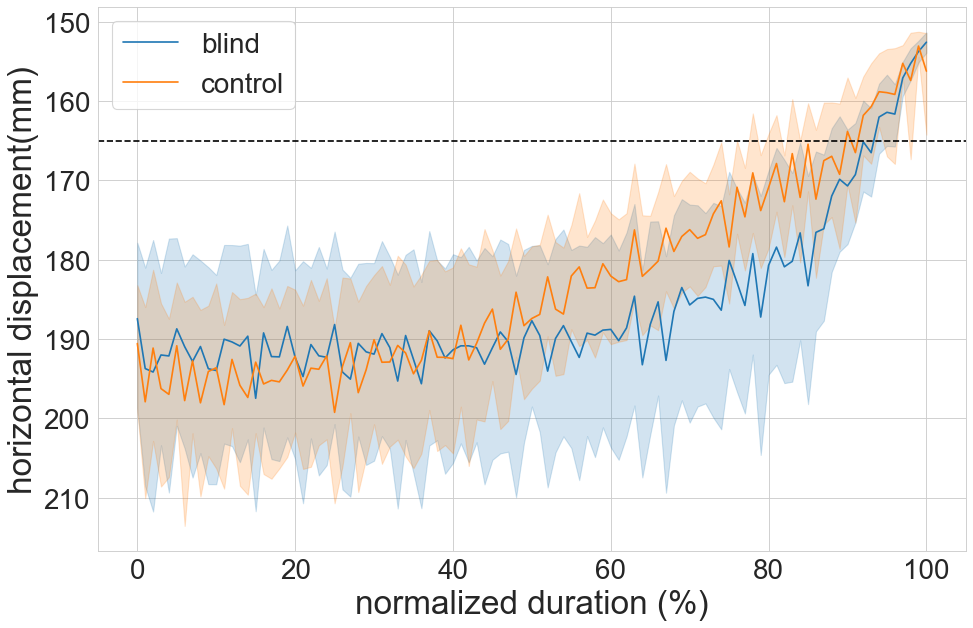

In [9]:
ax = plt.figure(figsize=(14,9), dpi= 80)
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_extention[scorer, 'WristL', 'x'],hue = data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_extention)
ax.invert_yaxis()
ax.axhline(165, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('horizontal displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig3= ax.get_figure()
fig3.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_WristL_x_condition_552022.png')

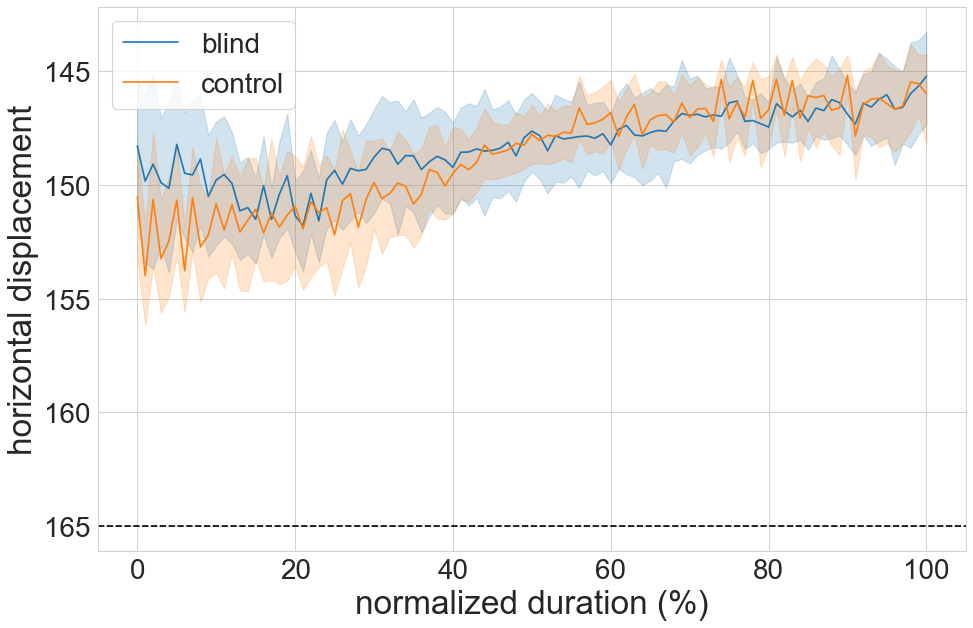

In [10]:
ax = plt.figure(figsize=(14,9), dpi= 80)
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_extention[scorer, 'Snout', 'x'],hue = data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_extention)
ax.invert_yaxis()
ax.axhline(165, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('horizontal displacement', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig4= ax.get_figure()
fig4.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_Snout_x_condition_552022.png')

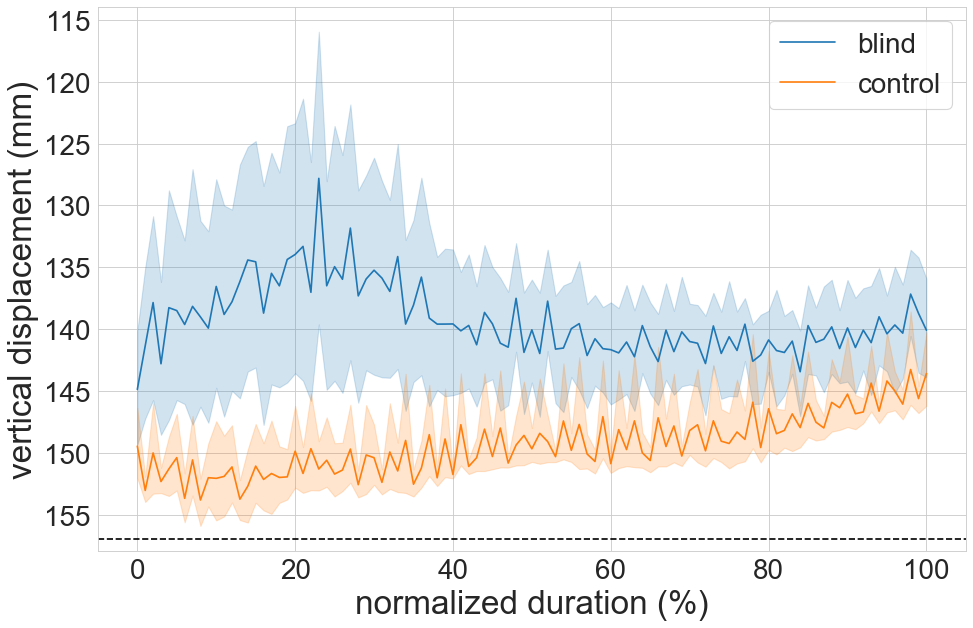

In [11]:
ax = plt.figure(figsize=(14,9), dpi= 80)
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_extention[scorer, 'Snout', 'y'],hue = data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_extention)
ax.invert_yaxis()
ax.axhline(157, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('vertical displacement (mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig5= ax.get_figure()
fig5.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_Snout_y_condition_552022.png')

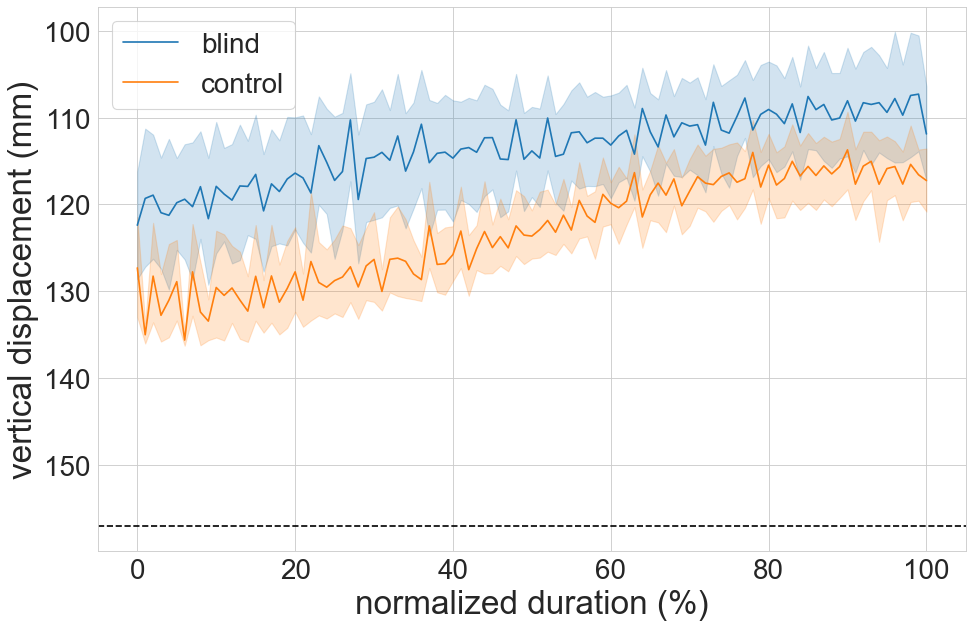

In [12]:
ax = plt.figure(figsize=(14,9), dpi= 80)
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_extention[scorer, 'EarL', 'y'],hue = data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_extention)
ax.invert_yaxis()
ax.axhline(157, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('vertical displacement (mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig6= ax.get_figure()
fig6.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_EarL_y_condition_552022.png')

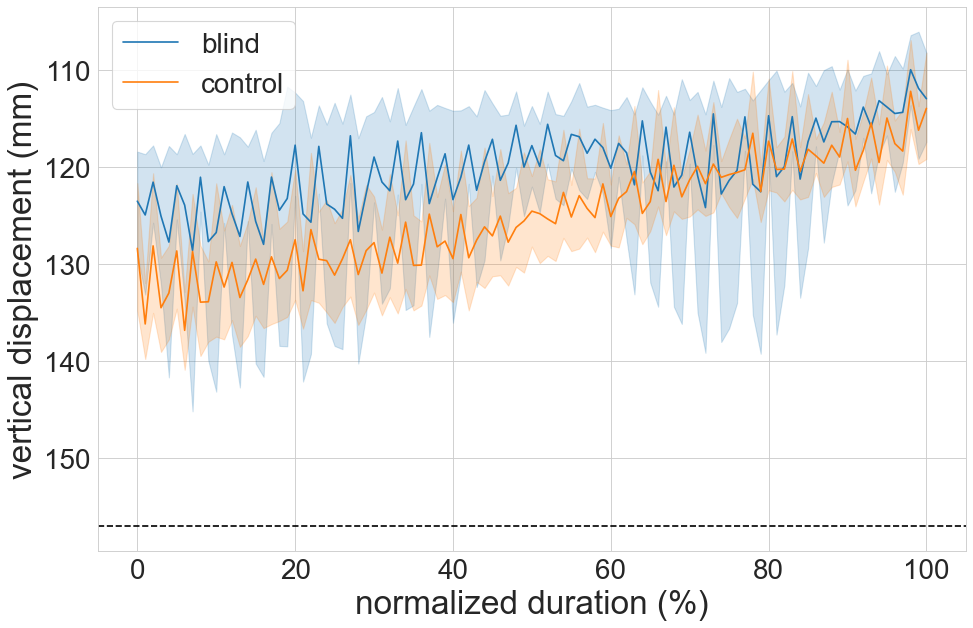

In [13]:
ax = plt.figure(figsize=(14,9), dpi= 80)
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_extention[scorer, 'EarR', 'y'],hue = data_singlereach_alladded_combined_extention[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_extention)
ax.invert_yaxis()
ax.axhline(157, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('vertical displacement (mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig7= ax.get_figure()
fig7.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_EarR_y_condition_552022.png')

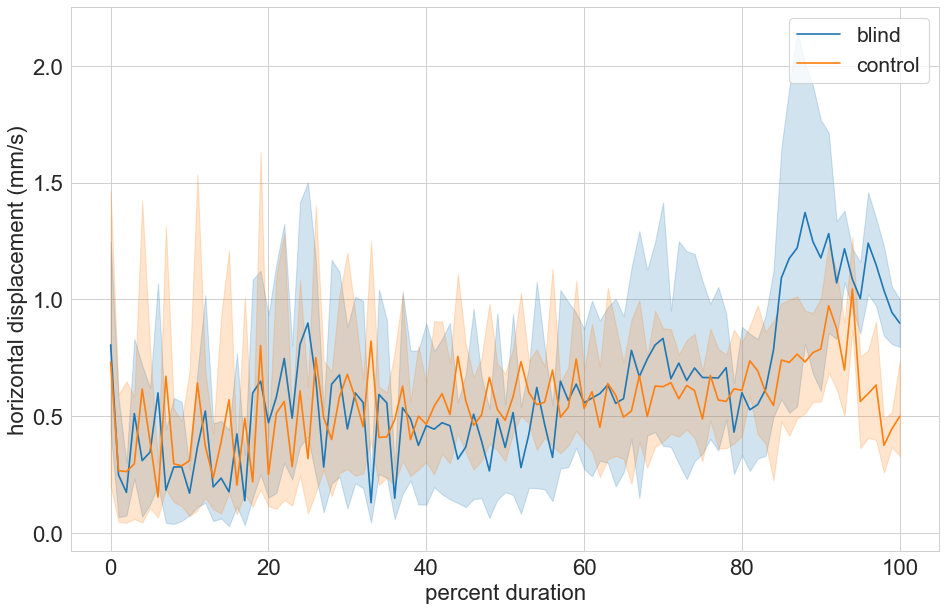

In [14]:
#Plot velocity RAW

#Lets see what it looks like plotted
ax = plt.figure(figsize=(14,9), dpi= 80)
my_pal= {'blind':'mediumblue','control':'crimson'}
ax = sns.lineplot(x='percent duration', y="speed",hue = 'Condition',data=data_speed_alladded_combined_extention)
plt.xlabel('percent duration', fontsize=20)
plt.ylabel('horizontal displacement (mm/s)', fontsize=20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)

plt.legend(loc=1, prop={'size': 19})

fig8= ax.get_figure()
fig8.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_WristL_speed_condition_552022.png')



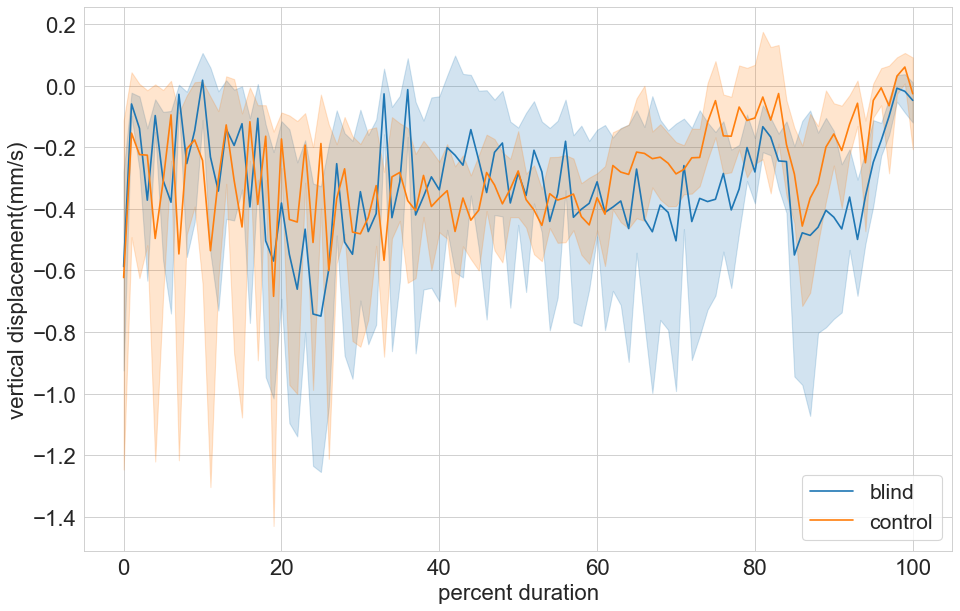

In [15]:
ax = plt.figure(figsize=(14,9), dpi= 80)
my_pal= {'blind':'mediumblue','control':'crimson'}
ax = sns.lineplot(x='percent duration', y="y",hue = 'Condition',data=data_velocity_alladded_combined_extention)
plt.xlabel('percent duration', fontsize=20)
plt.ylabel('vertical displacement(mm/s)', fontsize=20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.legend(loc=4, prop={'size': 19})

fig9= ax.get_figure()
fig9.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_WristL_velocity_y_condition_552022.png')



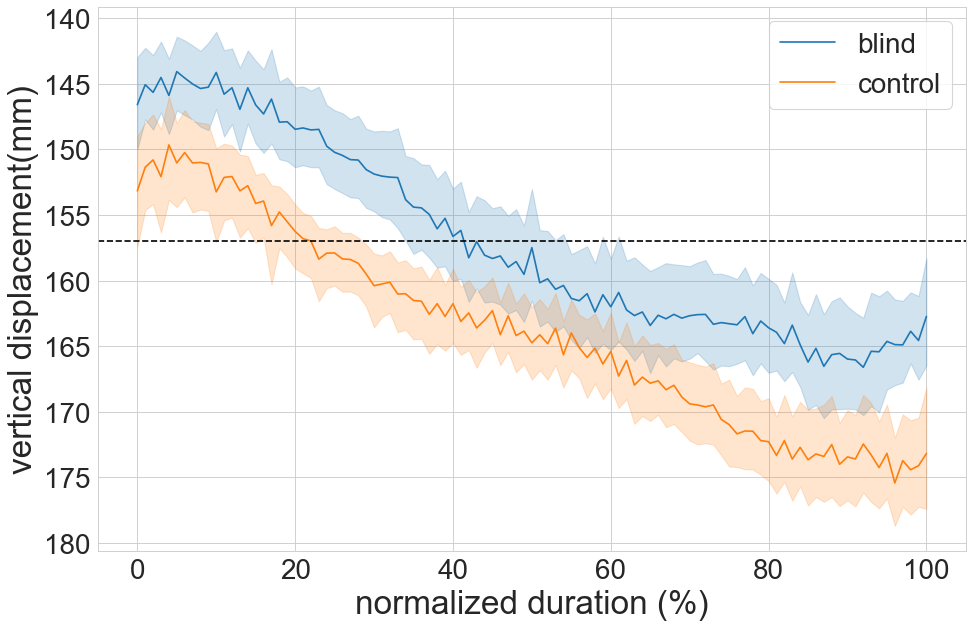

In [16]:
#RETRACTION ANALYSIS
ax = plt.figure(figsize=(14,9), dpi= 80)
sns.set_style('whitegrid')
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_retraction[scorer, 'WristL', 'y'],hue = data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'Condition'], data=data_singlereach_alladded_combined_extention)
ax.invert_yaxis()
ax.axhline(157, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('vertical displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig10= ax.get_figure()
fig10.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_retract_WristL_y_condition_552022.png')

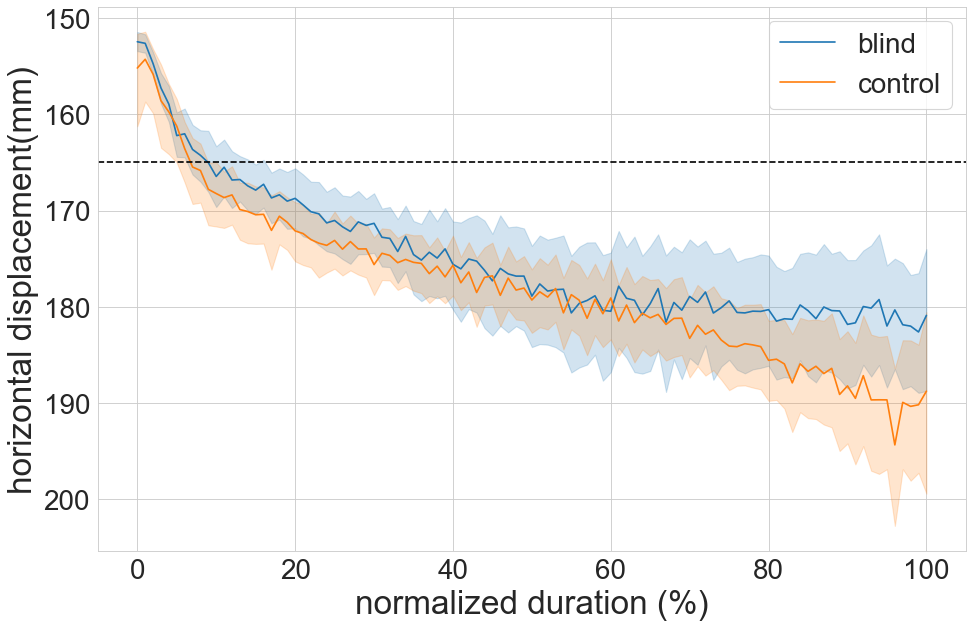

In [17]:
ax = plt.figure(figsize=(14,9), dpi= 80)
sns.set_style('whitegrid')
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_retraction[scorer, 'WristL', 'x'],hue = data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_extention)
ax.invert_yaxis()
ax.axhline(165, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('horizontal displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig11= ax.get_figure()
fig11.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_retract_WristL_x_condition_552022.png')

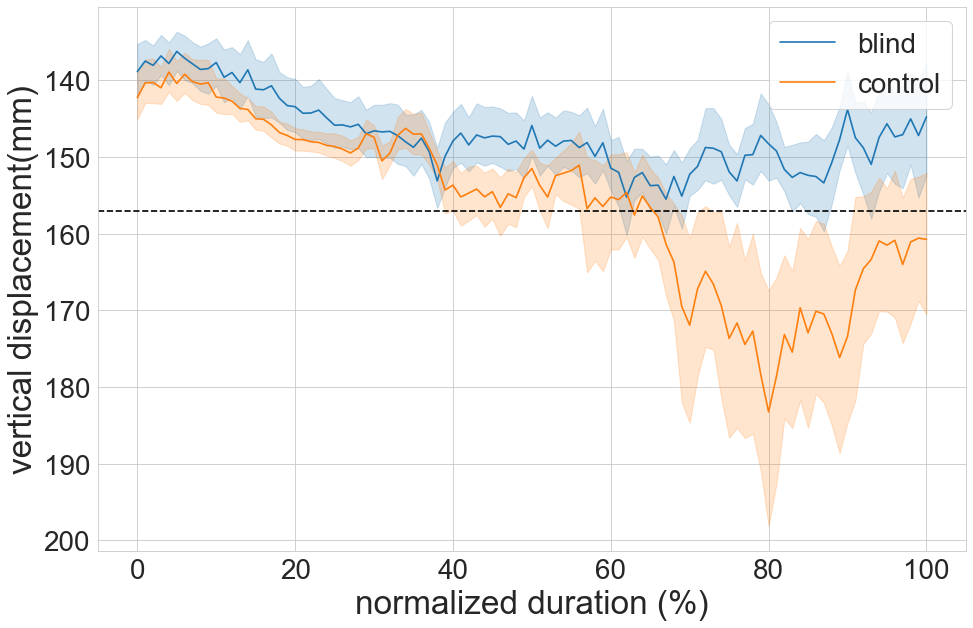

In [18]:
ax = plt.figure(figsize=(14,9), dpi= 80)
sns.set_style('whitegrid')
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_retraction[scorer, 'Snout', 'y'],hue = data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_retraction)
ax.invert_yaxis()
ax.axhline(157, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('vertical displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig13= ax.get_figure()
fig13.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_retract_Snout_y_condition_552022.png')

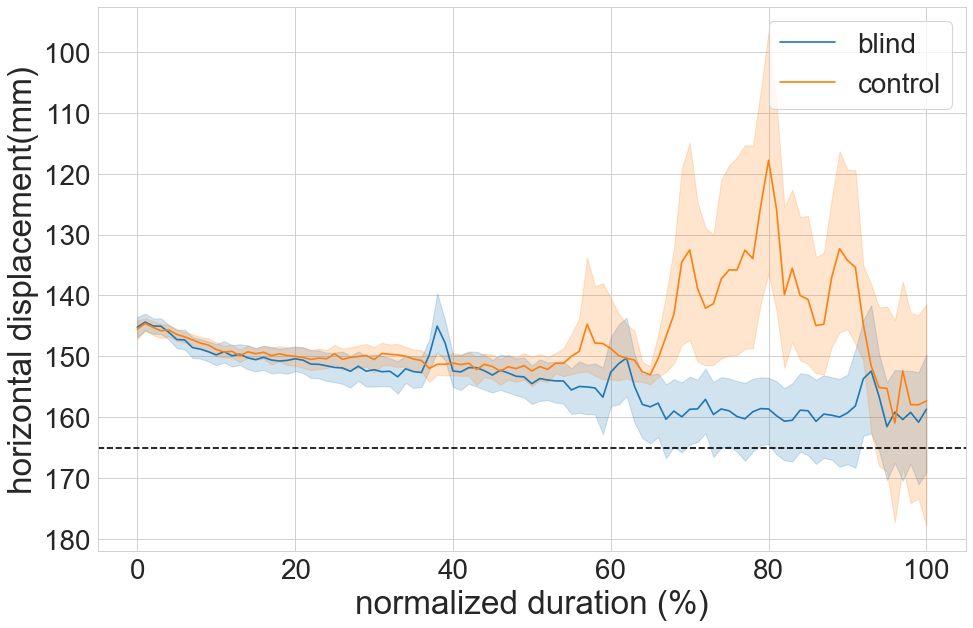

In [19]:
ax = plt.figure(figsize=(14,9), dpi= 80)
sns.set_style('whitegrid')
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_retraction[scorer, 'Snout', 'x'],hue = data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_retraction)
ax.invert_yaxis()
ax.axhline(165, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('horizontal displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig14= ax.get_figure()
fig14.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_retract_Snout_x_condition_552022.png')

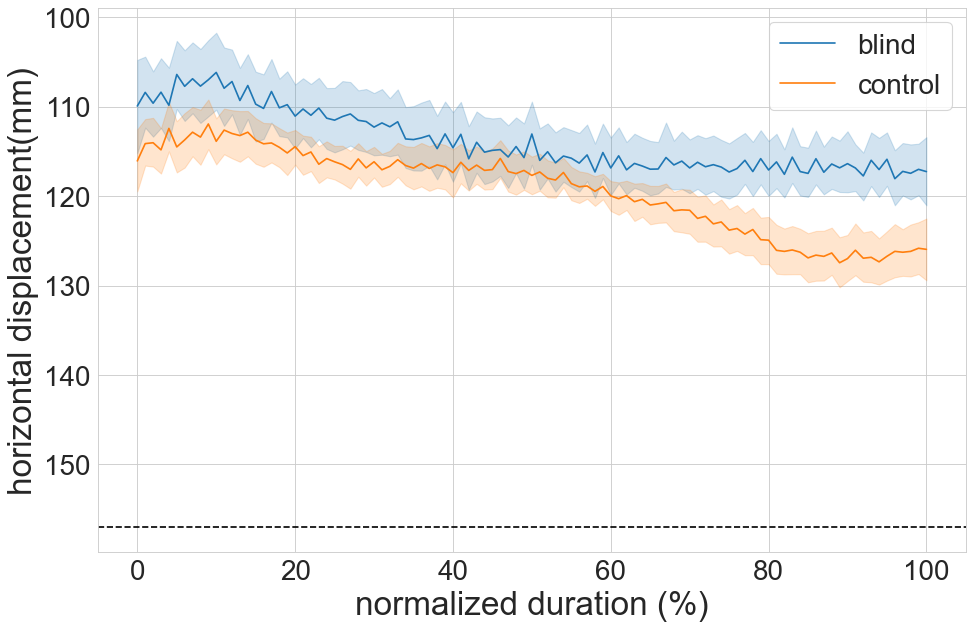

In [20]:
ax = plt.figure(figsize=(14,9), dpi= 80)
sns.set_style('whitegrid')
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_retraction[scorer, 'EarL', 'y'],hue = data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_retraction)
ax.invert_yaxis()
ax.axhline(157, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('horizontal displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig15= ax.get_figure()
fig15.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_retract_EarL_y_condition_552022.png')

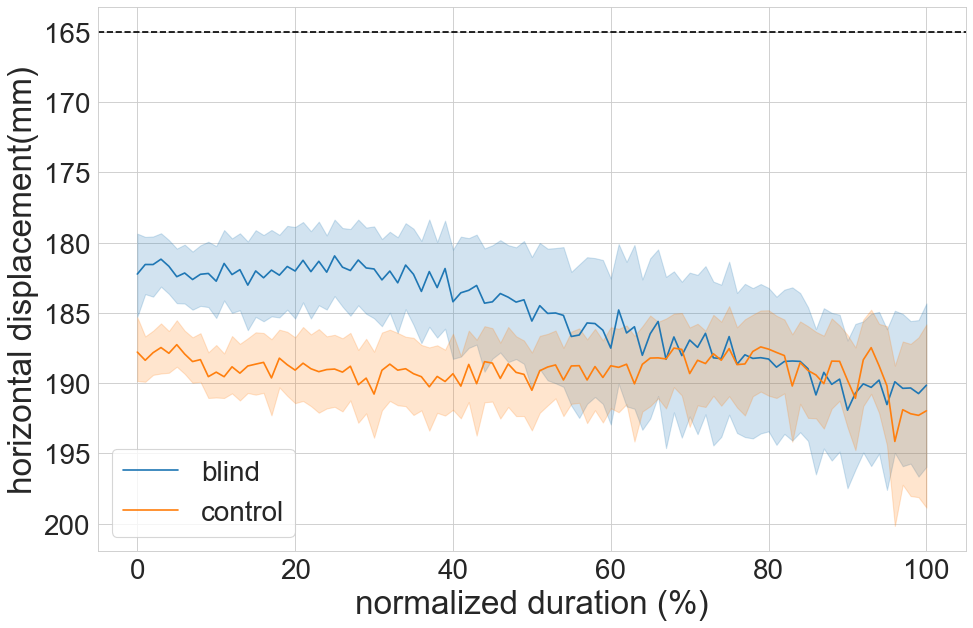

In [21]:
ax = plt.figure(figsize=(14,9), dpi= 80)
sns.set_style('whitegrid')
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_retraction[scorer, 'EarL', 'x'],hue = data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_retraction)
ax.invert_yaxis()
ax.axhline(165, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('horizontal displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig16= ax.get_figure()
fig16.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_retract_EarL_x_condition_552022.png')

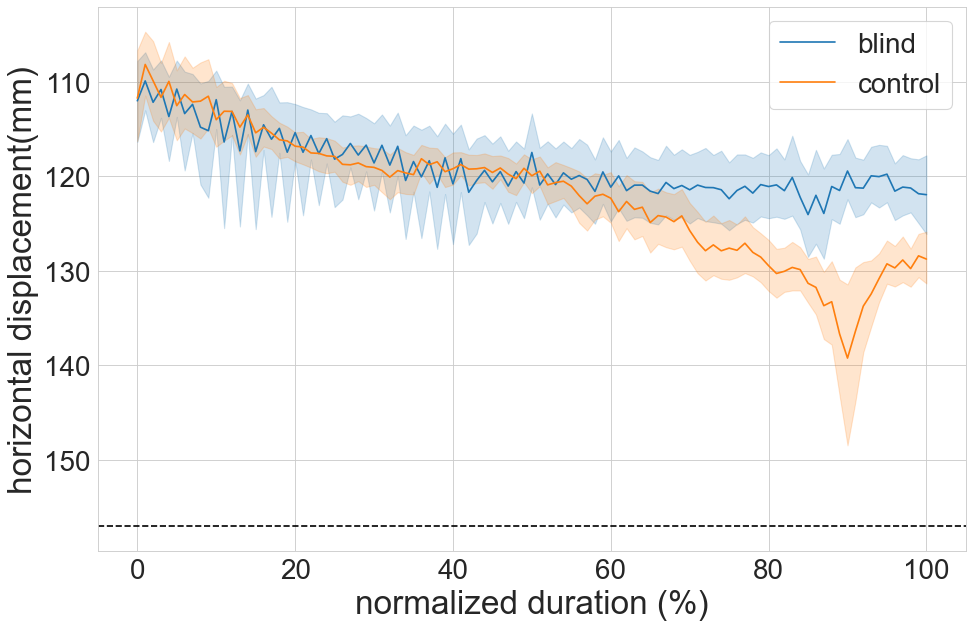

In [22]:
ax = plt.figure(figsize=(14,9), dpi= 80)
sns.set_style('whitegrid')
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_retraction[scorer, 'EarR', 'y'],hue = data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'Condition'],data=data_singlereach_alladded_combined_retraction)
ax.invert_yaxis()
ax.axhline(157, ls='--', c='k')
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('horizontal displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig17= ax.get_figure()
fig17.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_retract_EarR_y_condition_552022.png')

No handles with labels found to put in legend.


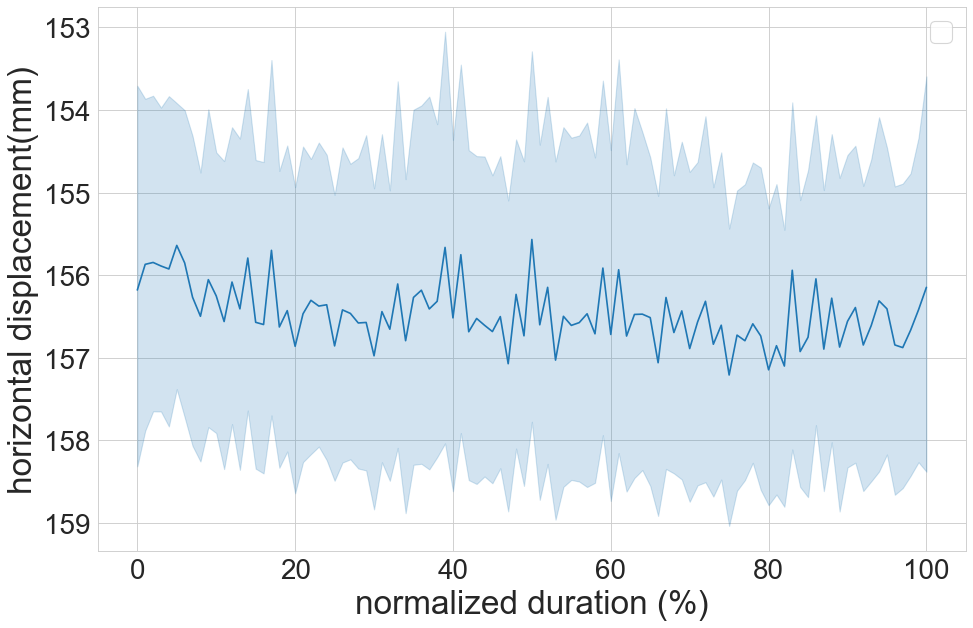

In [23]:
ax = plt.figure(figsize=(14,9), dpi= 80)
sns.set_style('whitegrid')
my_pal= {'blind':'mediumblue','control':'crimson'}
#invert_yaxis()
ax=sns.lineplot(x=data_singlereach_alladded_combined_retraction[scorer, 'Animal Infor', 'percent duration'], y=data_singlereach_alladded_combined_retraction[scorer, 'Platform', 'y'],data=data_singlereach_alladded_combined_retraction)
ax.invert_yaxis()
plt.xlabel('normalized duration (%)', fontsize=30)
plt.ylabel('horizontal displacement(mm)', fontsize=30)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(loc=0, prop={'size': 25})

fig17= ax.get_figure()
#fig17.savefig('/Users/carlospineda/Documents/Projects/brownbag/brownbag2022_retract_EarR_x_condition_552022.png')

IndexError: invalid index to scalar variable.

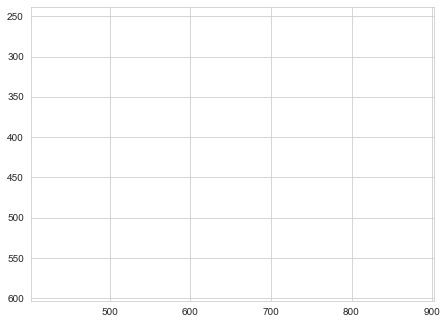

In [24]:
files = [file for file in os.listdir(path)]

viz = Visualizer2D(configCam3, path+file)
viz.view(show_axes=True, show_grid=True)